## <center> Практическое задание к лекции №4

**1.** В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).  

**2.** Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.  

---

## Подготовка к решению

In [72]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [73]:
# сгенерируем данные
classification_data = None
classification_labels = None

classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    # flip_y=0.15,
    # weights=[0.9],
    random_state=None
)

# print(classification_data[:10])

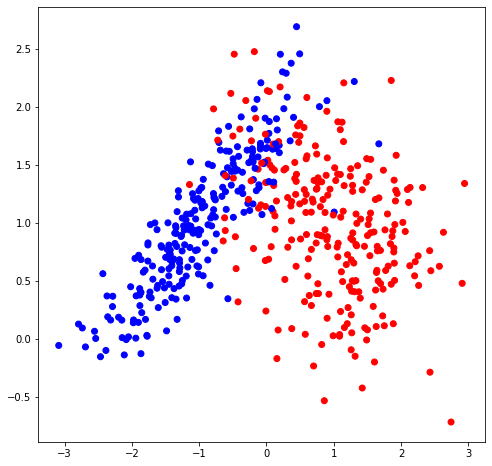

In [74]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [75]:
# Реализуем класс узла. Добавлены реквизиты, которые в дальнейшем помогают визуализации дерева решений.

class Node:
    
    def __init__(self, index, t, gini, true_branch, false_branch, true_samples, false_samples):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.gini = gini  # значение gini
        self.samples = true_samples + false_samples
        self.true_samples = true_samples
        self.false_samples = false_samples
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [76]:
# И класс терминального узла (листа). Добавлены реквизиты, которые в дальнейшем помогают визуализации дерева решений.

class Leaf:
    
    def __init__(self, data, labels, gini,  true_samples, false_samples):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.gini = gini  # значение gini
        self.samples = true_samples + false_samples
        self.true_samples = true_samples
        self.false_samples = false_samples
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [77]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [78]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [79]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [80]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index, current_gini

In [81]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index, gini = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels, gini) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, gini, true_branch, false_branch)

In [82]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [83]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [84]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    


In [85]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [86]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


## Решение:

**1.** В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).  

---

- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз. (min_leaf)

- Ограничение максимального количества признаков. (max_features)

In [87]:
# Нахождение наилучшего разбиения

#  минимальное количество объектов в узле теперь будет задано в качестве парамета min_leaf в функции find_best_split
#  максимальное количество признаков теперь будет задано в качестве парамета max_features в функции find_best_split

def find_best_split(data, labels, min_leaf = 5, max_features = None):
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    best_true_data = []
    best_false_data = []
    
    n_features = data.shape[1] if max_features is None else max_features # Ограничение максимального количества признаков
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается объектов менее, чем в ограничении min_leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                best_true_data, best_false_data = true_data, false_data

    return best_quality, best_t, best_index, current_gini, best_true_data, best_false_data

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.

In [88]:
# Построение дерева с помощью рекурсивной функции, добавлено ограничение глубины, и минимальное количество элементов в листе:

def build_tree(data, labels, max_depth=None, min_leaf = 5, max_features = None):

    # Если глубина не задана, будем строить по максимуму
    max_depth = max_depth if max_depth is not None else data.shape[0]*data.shape[1]

    quality, t, index, gini, best_true_data, best_false_data = find_best_split(data, labels, min_leaf, max_features)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или достигли максимальной глубины
    if quality == 0 or max_depth == 0 :
        return Leaf(data, labels, gini, len(best_true_data), len(best_false_data))

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева, уменьшая их глубину
    true_branch = build_tree(true_data, true_labels, max_depth = max_depth-1, min_leaf = min_leaf, max_features = max_features)
    false_branch = build_tree(false_data, false_labels, max_depth = max_depth-1, min_leaf = min_leaf, max_features = max_features)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, gini, true_branch, false_branch, len(true_data), len(false_data))

In [89]:
from sklearn import model_selection
from sklearn import tree
import graphviz

In [90]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [91]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 3, min_leaf = 15)

In [92]:
print_tree(my_tree)

Индекс 0
Порог -0.0910846348452028
--> True:
  Индекс 0
  Порог -0.7446826391756305
  --> True:
    Индекс 1
    Порог 1.1448258021087367
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 1
    Порог 1.6255450915413299
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
--> False:
  Индекс 1
  Порог 1.580874520531589
  --> True:
    Индекс 0
    Порог 0.14904598808807534
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.4029921483301415
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0


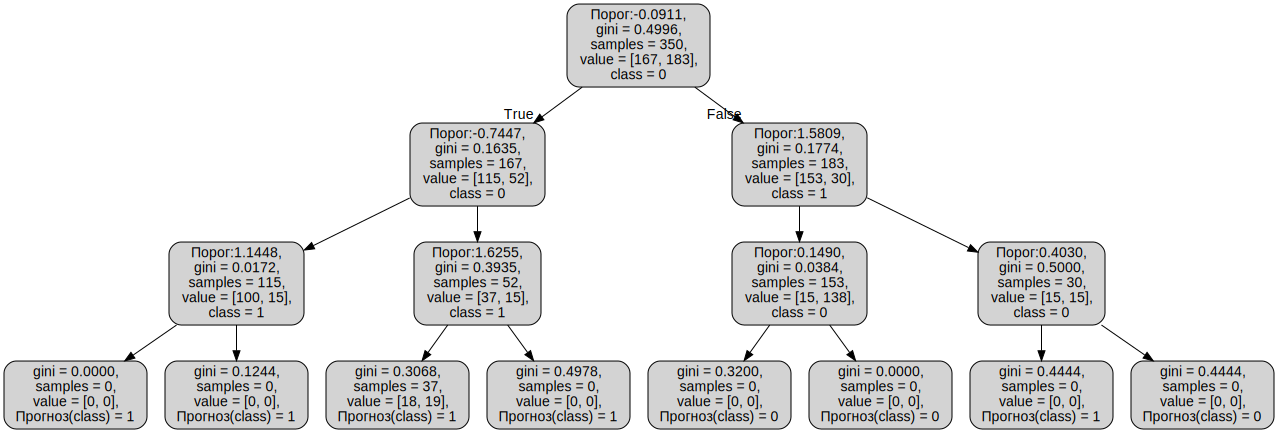

In [93]:
# Конвертация дерева в структуру для копмоненты graphviz
def convert_my_tree_to_dot(my_tree_node):

    dot = None
    dot = graphviz.Digraph(comment = 'My tree')
    dot.attr('node', shape = 'box', style = 'filled, rounded', fontname = 'helvetica')
    dot.attr('edge', fontname = 'helvetica')


    next_index = 1
    nodes_queue = []

    nodes_queue.append((my_tree_node, str(next_index)))
    label_string = f'Порог:{my_tree_node.t:.4f}, \n gini = {my_tree_node.gini:.4f},\n samples = {my_tree_node.true_samples + my_tree_node.false_samples},\n value = [{my_tree_node.true_samples}, {my_tree_node.false_samples}], \n  class = {str(my_tree_node.index)}'
    dot.node(str(next_index), label=label_string)

    # Дальнейший алгоритм прост.
    # 1) Берем последнюю вершину из очереди;
    # 2) Добавляем в дерево для отражения соответствующую информцию. Узел + связь.;
    # 3) Если это НЕ лист, то добавляем в очередь очередной узел;
    # 4) Удаляем из очереди обработанный элемент.
    # 5) Когда очередь пуста - заканчиваем алгоритм.

    iteration_flag = True
    while iteration_flag:

        # Если очередь пуста, то нужно прекращать работу этой процедуры.
        if len(nodes_queue) == 0:
            iteration_flag = False
            continue

        current_nodes_queue_index = len(nodes_queue)-1
        current_node = nodes_queue[current_nodes_queue_index]
        
        # Если лист, то удаляем элемент из очереди на обработку и переходим к следующему.
        # По замыслу автора такого элемента в очереди быть не должно. Но в процессе отладки может и затесаться. Поэтому я решил поставить защиту "от дурака".
        # Лишня проверка в учебных целях не повредит. Хотя, по канонам питона нужно булобы обработать исключение.
        if isinstance(current_node[0], Leaf):
            nodes_queue.remove(current_node)
            iteration_flag = False
            continue


        for current_branch in (current_node[0].true_branch, current_node[0].false_branch):
            next_index += 1
            next_my_tree_node = current_branch
            if isinstance(next_my_tree_node, Leaf): # В случае листа и узла отображаемые данные будут оличаться.
                label_string = f'gini = {next_my_tree_node.gini:.4f},\n samples = {next_my_tree_node.true_samples + next_my_tree_node.false_samples},\n value = [{next_my_tree_node.true_samples}, {next_my_tree_node.false_samples}],\n Прогноз(class) = {str(next_my_tree_node.prediction)}'
            else: # Если НЕ лист, то к добавлению узла в отображаемом дереве, добавляем элемент в очередь (nodes_queue) для дальнейшей проработки
                label_string = f'Порог:{next_my_tree_node.t:.4f}, \n gini = {next_my_tree_node.gini:.4f},\n samples = {next_my_tree_node.true_samples + next_my_tree_node.false_samples},\n value = [{next_my_tree_node.true_samples}, {next_my_tree_node.false_samples}], \n  class = {str(next_my_tree_node.index)}'
                nodes_queue.append((next_my_tree_node, str(next_index)))

            # Добавляем лист в отображаемом дереве и связку с текущим обрабатываемым узлом
            dot.node(str(next_index), label=label_string)
            if next_index == 2:
                headlabel_string = 'True'
            elif next_index == 3:
                headlabel_string = 'False'
            else:
                headlabel_string = ''
            dot.edge(current_node[1], str(next_index), constraint = 'true', headlabel=headlabel_string)

        nodes_queue.remove(current_node)

    return dot

dot = convert_my_tree_to_dot(my_tree)
dot


In [94]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [95]:
# Точность на тренировочной выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

Text(0.5, 1.0, 'Test accuracy=91.33')

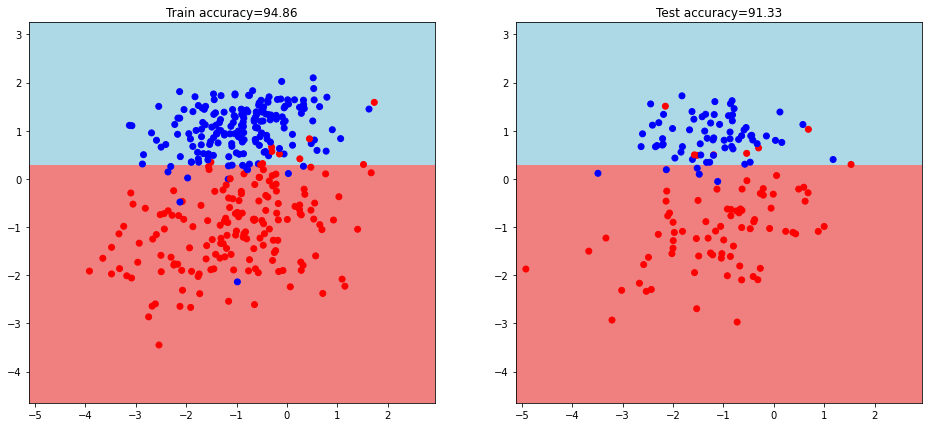

In [46]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Следующий эксперимент. Другой набор параметров.

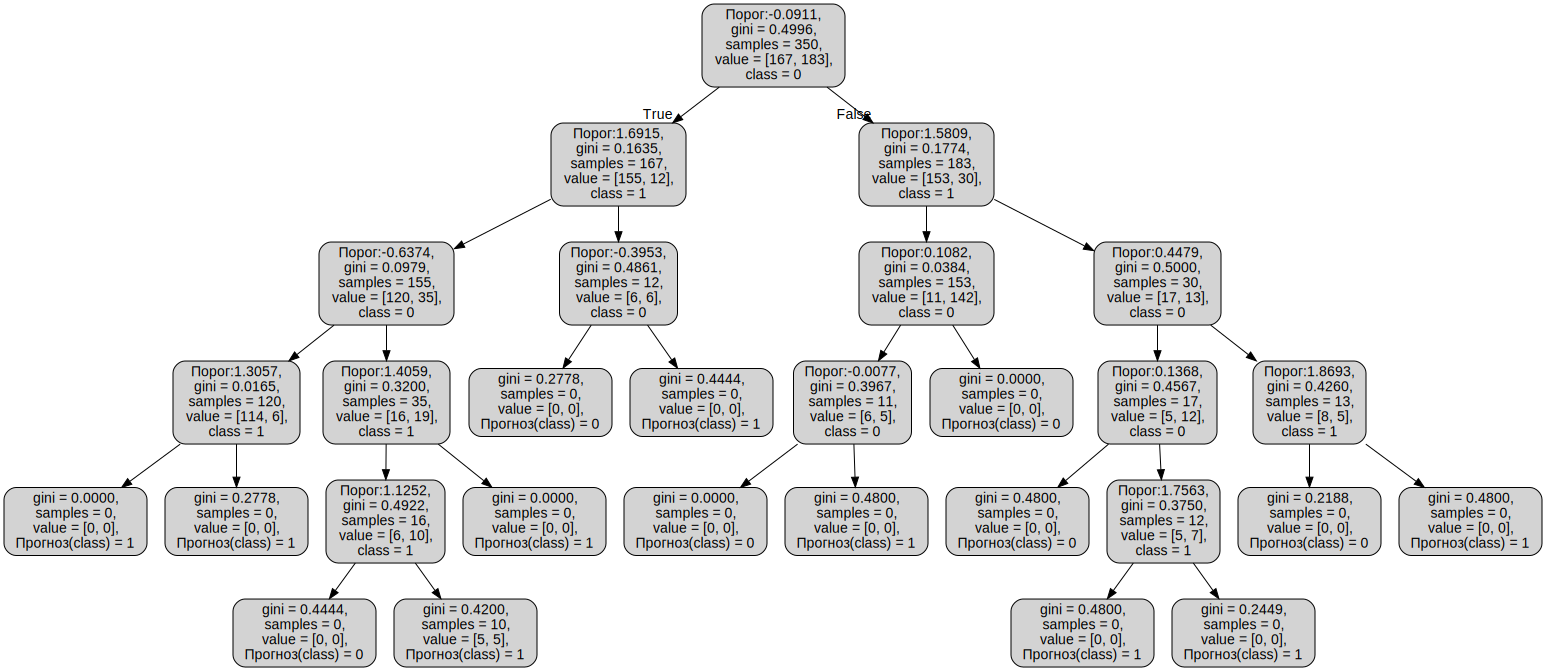

In [96]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 5, min_leaf = 5)
dot = convert_my_tree_to_dot(my_tree)
dot

In [97]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [98]:
# Точность на тренировочной выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

Text(0.5, 1.0, 'Test accuracy=80.00')

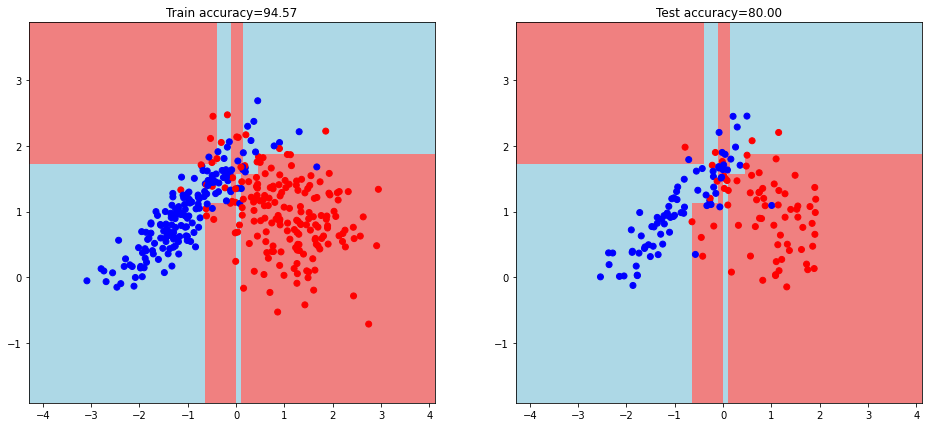

In [99]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Следующий эксперимент. Другой набор параметров.

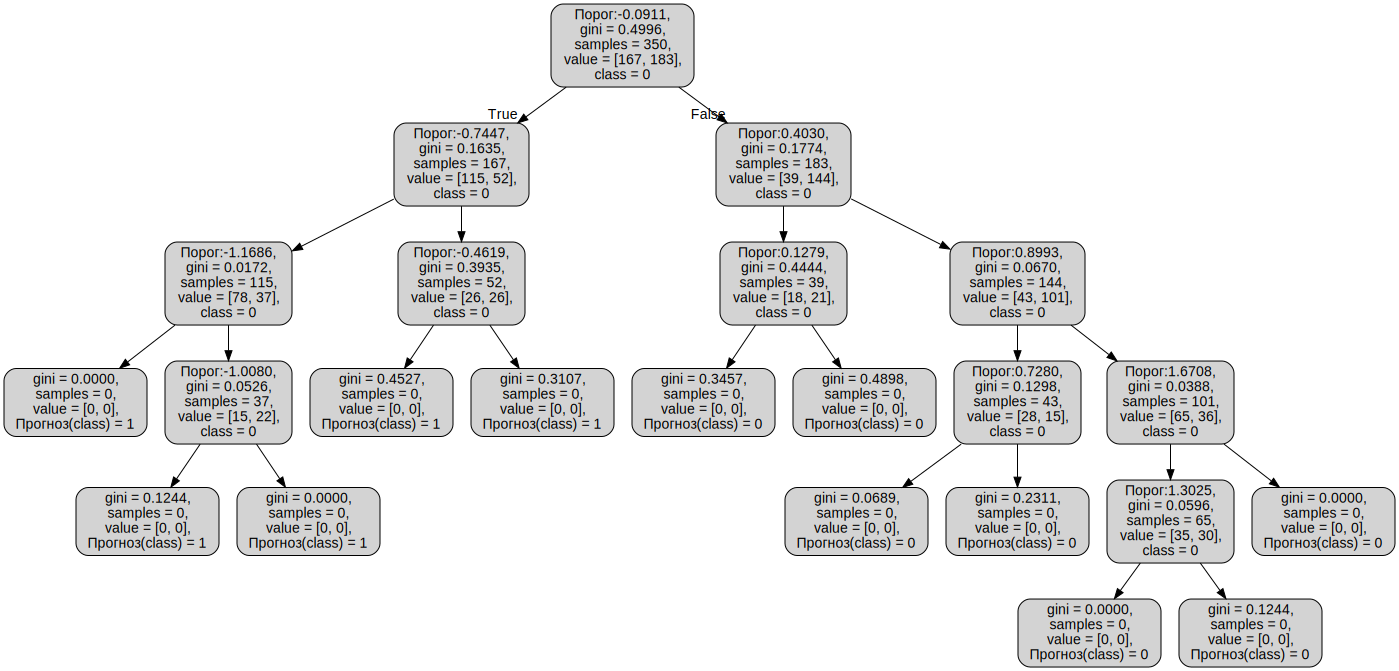

In [100]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 5, min_leaf = 15, max_features = 1)
dot = convert_my_tree_to_dot(my_tree)
dot

In [101]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [102]:
# Точность на тренировочной выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

Text(0.5, 1.0, 'Test accuracy=81.33')

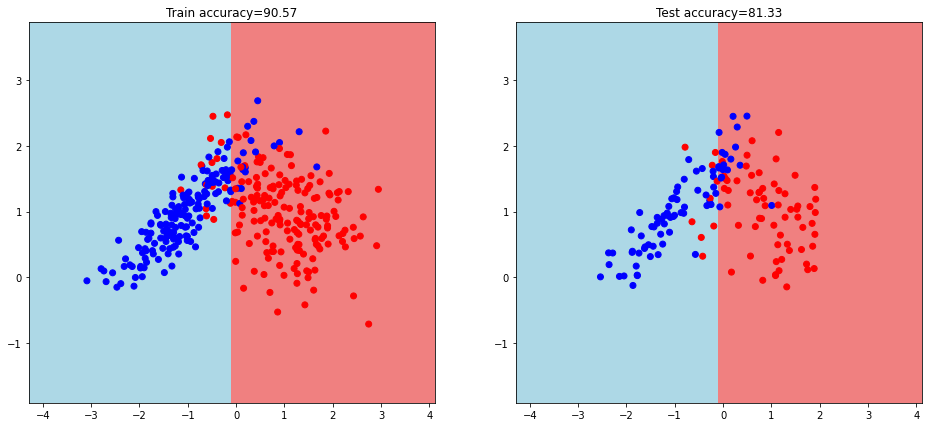

In [103]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

**2.** Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений. 

---

In [104]:
def var(y):
    avg = sum(y)/len(y)
    return sum([(yi-avg)**2 for yi in y])/len(y)

def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * var(left_labels) - (1 - p) * var(right_labels) 

In [106]:
def find_best_split(data, labels, min_leaf = 5, max_features = None):
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    best_true_data = []
    best_false_data = []
    
    n_features = data.shape[1] if max_features is None else max_features # Ограничение максимального количества признаков
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается объектов менее, чем в ограничении min_leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                best_true_data, best_false_data = true_data, false_data

    return best_quality, best_t, best_index, current_gini, best_true_data, best_false_data

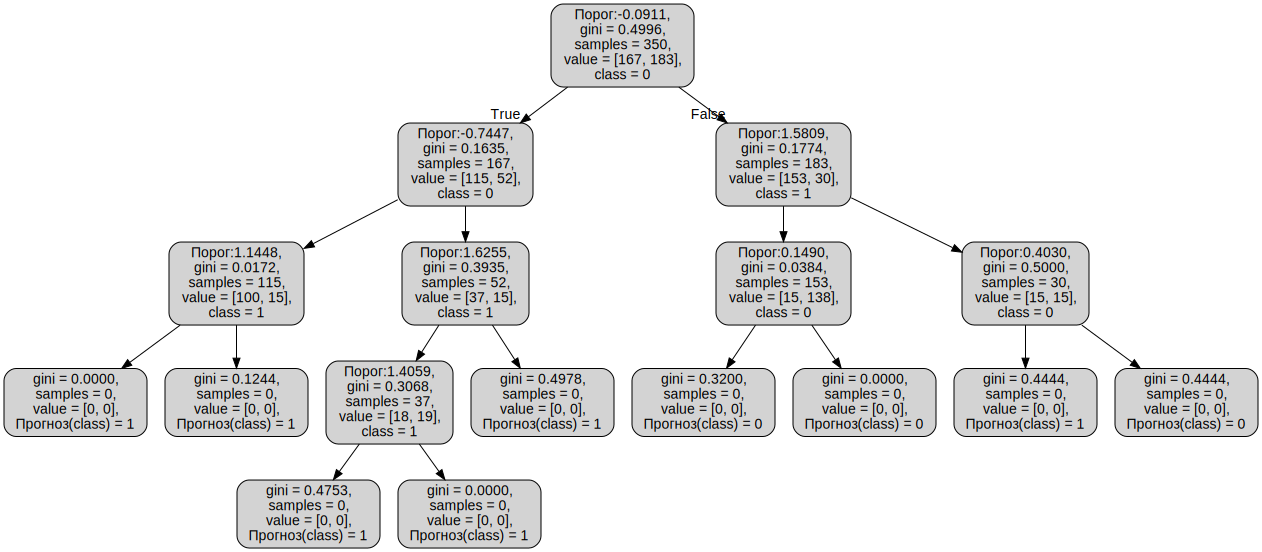

In [107]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 4, min_leaf = 15)
dot = convert_my_tree_to_dot(my_tree)
dot

In [108]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [109]:
# Точность на тренировочной выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

Text(0.5, 1.0, 'Test accuracy=90.00')

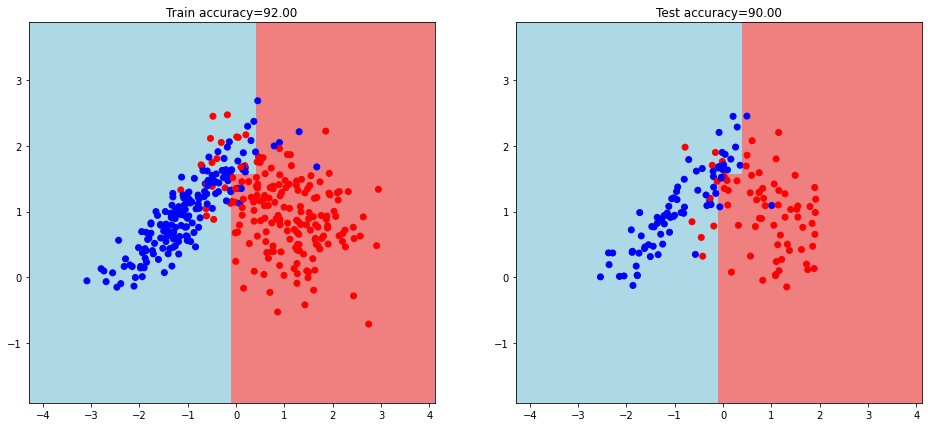

In [110]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')